### A股市场月度收益的fama-macbeth回归：规模效应的单因子检验
（1）第一部分：从TuShare拿到股票数据，然后进行fama-macbeth回归； <br/>
（2）第二部分：从中财金融学院资产研究中心网站下载fama-french风格的SMB因子数据； <br/>
（3）第三部分：合并两个计算结果，并画图对比

### (1) fama-macbeth回归
#### (1.1) get_data的几个函数

In [1]:
import tushare as ts
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

ts.set_token('')

pro = ts.pro_api()

""""
获取交易日期的函数：
获取月末交易日期tr_mon_last_date、月末日期mon_last_date
拿日数据时要看交易日期情况(市值数据)；
拿月数据时要看自然日期情况(收益数据)
''"""
def get_month_last_data(start_date, end_date):
    trdate = pro.trade_cal(start_date=start_date, end_date=end_date)
    trdate['year'] = trdate['cal_date'].apply(lambda x: int(x[0:4]))  # 添加一个year、month列
    trdate['month'] = trdate['cal_date'].apply(lambda x: int(x[4:6]))
    tr_mon_last_date = trdate[ trdate['is_open'] == 1 ].groupby(['year', 'month']).last()
    tr_mon_last_date = list(tr_mon_last_date.cal_date)
    mon_last_date = trdate.groupby(['year', 'month']).last()
    mon_last_date = list(mon_last_date.cal_date)
    
    return tr_mon_last_date, mon_last_date

""""
获取股票数据的函数：
依据输入的日期来获取TS该日期的全部股票数据
注意：关注TS的单次拉取限制是否超过股票总数（否则会漏数）
''"""
# 获取月末交易日所有股票的市值数据
def get_mon_mv_data(datelist):
    mkt_value_monthly = pd.DataFrame()
    for tr_date in datelist:
        df = pro.daily_basic(ts_code='', trade_date=tr_date, fields='ts_code, trade_date, total_mv')
        mkt_value_monthly = mkt_value_monthly.append(df)
    # 计算市值对数，然后进行简单的归一化预处理(mean=0, std=1)
    log_mv_monthly = mkt_value_monthly.copy()
    log_mv_monthly['year']  = log_mv_monthly['trade_date'].apply(lambda x: int(x[0:4]))
    log_mv_monthly['month'] = log_mv_monthly['trade_date'].apply(lambda x: int(x[4:6]))
    log_mv_monthly['log_mv'] = np.log(mkt_value_monthly['total_mv'])
    log_mv_monthly = log_mv_monthly.sort_values(['trade_date', 'ts_code']).reset_index(drop=True)
    # 开始归一化处理
    log_mv_mon_gp = log_mv_monthly.groupby('trade_date')
    log_mv_norm = np.zeros((len(log_mv_monthly), ))
    for date, group in log_mv_mon_gp:  # 每个group（时间截面）单独地归一化
        norm = preprocessing.scale(group['log_mv'])
        norm_idx = group.index
        log_mv_norm[norm_idx] = norm
    log_mv_monthly['log_mv_norm'] = pd.DataFrame({'log_mv_norm': log_mv_norm})
    # 获取上一个月月末的归一化市值
    log_mv_monthly = log_mv_monthly.sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
    log_mv_monthly['b_log_mv_norm_1'] = log_mv_monthly['log_mv_norm'].shift(1)
    log_mv_monthly['b_code_1'] = log_mv_monthly['ts_code'].shift(1)
    log_mv_monthly = log_mv_monthly[ log_mv_monthly['ts_code'] == log_mv_monthly['b_code_1'] ]
    # 最后清理一下表
    log_mv_monthly = log_mv_monthly[['year', 'month', 'ts_code', 'b_log_mv_norm_1']]
    
    return log_mv_monthly


# 获取个股的月度收益
def get_mon_ret_data(datelist):
    ret_monthly_raw = pd.DataFrame()
    for tr_date in datelist:
        df = pro.monthly(trade_date=tr_date, fields='ts_code, trade_date, pct_chg')
        ret_monthly_raw = ret_monthly_raw.append(df)
    # 获取个股下一个月的收益
    ret_monthly = ret_monthly_raw.copy()
    ret_monthly['year']  = ret_monthly['trade_date'].apply(lambda x: int(x[0:4]))
    ret_monthly['month'] = ret_monthly['trade_date'].apply(lambda x: int(x[4:6]))
    ret_monthly['rR_mon'] = ret_monthly['pct_chg'] / 100
    ret_monthly = ret_monthly.sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
    # 最后清理一下表
    ret_monthly = ret_monthly[['year', 'month', 'ts_code', 'rR_mon']]

    return ret_monthly

#### (1.2) 调用函数生成数据，然后进行fama-macbeth回归

In [2]:
# 调用函数，生成并合并数据
# 生成数据
tr_mon_last_date, mon_last_date = get_month_last_data(start_date='20021201', end_date='20181231')
log_mv_monthly = get_mon_mv_data(tr_mon_last_date)
ret_monthly = get_mon_ret_data(mon_last_date)
# merge by (date, code)
merge_value = ['year', 'month', 'ts_code']
total = pd.merge(log_mv_monthly, ret_monthly, left_on=merge_value, right_on=merge_value)


# 进行Fama-Macbeth回归
result = {}
model = LinearRegression(fit_intercept=False)

for date, group in total.groupby(['year', 'month']):
    x_gp = group['b_log_mv_norm_1'].values.reshape(-1, 1)
    y_gp = group['rR_mon'].values.reshape(-1, 1)
    model.fit(x_gp, y_gp)
    b = model.coef_
    result[date] = {'b_log_mv_norm_1': b[0][0]}
# beta为结果df
beta = pd.DataFrame(result).T
print('fama-machbeth回归得到的beta系数的时序：')
print(beta.head())

fama-machbeth回归得到的beta系数的时序：
        b_log_mv_norm_1
2003 1        -0.011324
     2        -0.005020
     3         0.014787
     4         0.030734
     5         0.003045


### (2) 去网站拿一下Fama-French类型的因子收益

In [5]:
from requests_html import HTMLSession
import pandas as pd
import zipfile
import os
import shutil

def get_fama_french_style_return(url, file_name, csv_name, startdt, enddt):
    # 建立一个session来抓html
    session = HTMLSession()
    r = session.get(url)
    # 拿到所有的links，然后找到包含了'/docs/'的
    links = list(r.html.absolute_links)
    link = [ i for i in links if i.find('/docs/') > 0 ][0]
    # 从links里get数据，然后写到文件file_location里面(一个.zip文件)
    file_name = 'three_four_five_factor_monthly'
    file_name_all = file_name + '.zip'
    with open(file_name_all, 'wb+') as data_file:
        r1 = session.get(link)
        data_file.write(r1.content)
    # 解压缩zip文件包，读入csv数据
    f = zipfile.ZipFile(file_name_all, 'r')
    csv_location = file_name + '/' + csv_name
    f.extract(csv_location)
    factor_ret = pd.read_csv(csv_location)
    # 一些简单的处理
    factor_ret = factor_ret[ (factor_ret['trdmn'] > startdt) & (factor_ret['trdmn'] < enddt) ]
    factor_ret.index = beta.index
    factor_ret['bms'] = -factor_ret['smb']  # 将SMB转为BMS，和回归结果一致
    factor_ret = factor_ret[['bms']]
    # 删除文件
    os.remove(file_name_all)
    shutil.rmtree(file_name)

    return factor_ret
    
url = 'http://sf.cufe.edu.cn/kxyj/kyjg/zgzcglyjzx/zlxzzq/111422.htm'  # 网址
file_name = 'three_four_five_factor_monthly'
csv_name = 'fivefactor_monthly.csv'
factor_ret = get_fama_french_style_return(url, file_name, csv_name, 200212, 201812)

print('fama-french风格的因子收益时序：')
print(factor_ret.head())

fama-french风格的因子收益时序：
             bms
2003 1 -0.020429
     2 -0.009213
     3  0.017321
     4  0.035858
     5  0.015023


### （3）画图比较一下两者的结果

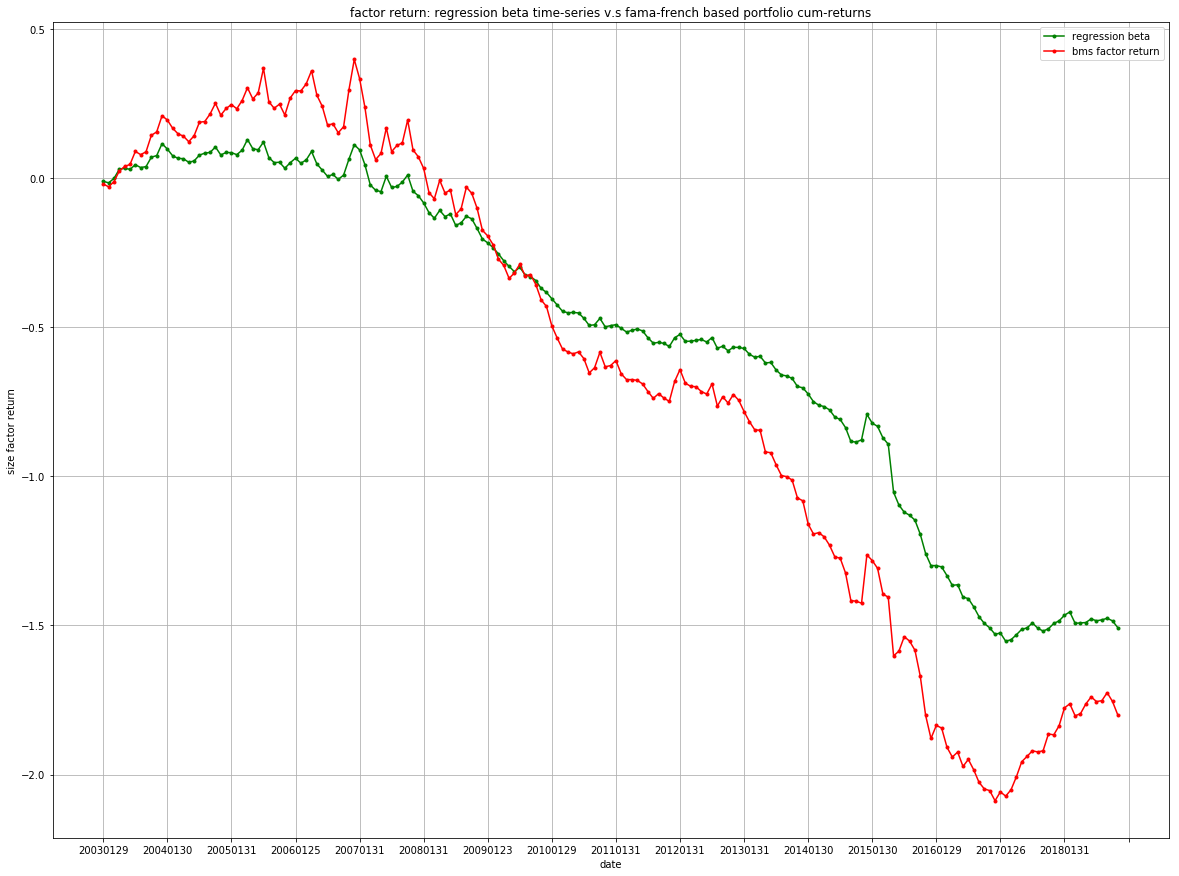

In [6]:
# 合并一下两个结果，并画图对比
contrast = pd.merge(beta, factor_ret, left_index=True, right_index=True)
contrast['beta_size_cumsum'] = contrast['b_log_mv_norm_1'].cumsum()
contrast['bms_cumsum'] = contrast['bms'].cumsum()

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

xmajorLocator = MultipleLocator(12)  # 让x轴不那么密集

x_date = tr_mon_last_date[1:-1]
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
plt.grid()
plt.title('factor return: regression beta time-series v.s fama-french based portfolio cum-returns')
plt.xlabel('date')
plt.ylabel("size factor return")
ax.xaxis.set_major_locator(xmajorLocator)
plt.plot(x_date, contrast.beta_size_cumsum, '.g-', label="regression beta")
plt.plot(x_date, contrast.bms_cumsum, '.r-', label="bms factor return")
plt.legend()